In [1]:
from sklearn.linear_model import LogisticRegression
import torch
import pickle
import torch.nn as nn
from tqdm import tqdm
from utils import float32_to_int16, int16_to_float32
from einops import rearrange #might need to do pip install einops
import warnings
import matplotlib.pyplot as plt
import numpy as np

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# read in pickle data
with open('activations.pkl', 'rb') as f:
    all_xs = pickle.load(f) # shape: (batch_size, num_layers, k, model_dim)

# shuffle all_xs
all_xs = all_xs[torch.randperm(all_xs.size()[0])]
train_split = int(.8 * len(all_xs))
x_train = all_xs[:train_split]
x_test = all_xs[train_split:]

In [42]:
class Probe(nn.Module):
    def __init__(self):
        super().__init__()
        self.probe = nn.Linear(768,1, bias=True).to(torch.float32)
    def forward(self, x):
        return torch.sigmoid(self.probe(x))
    def complement(self):
        p = Probe()
        p.probe.weight.data = -self.probe.weight.data
        p.probe.bias.data = -self.probe.bias.data
        return p

def gabe_loss(data, probe):
    probs = probe(data).squeeze(dim=-1)
    probs = probs.sort(dim=-1, descending=True).values
    l_big = (1 - probs[:,0])**2
    l_small = (probs[:,1:]**2).sum(dim=-1)
    return (l_big + l_small).mean()

def probe_acc(data, probe):
    with torch.no_grad():
        probs = probe(data).squeeze(dim=-1)
        correct = (probs.max(dim=-1).indices == 0).sum().item()
    return correct/len(data)


def lr_probe_loss(data, probe):
    probs = probe(data).squeeze(dim=-1)
    l_fst = probs[:,0].log()
    l_snd = (1 - probs[:,1:]).log().sum(dim=-1)
    return (l_fst + l_snd).mean()

In [12]:
# do logistic regression with scikit-learn
lr_accs = {}
lr_probes = {}

num_classes = 4
import warnings
for layer in range(1,13):
    lr = LogisticRegression(max_iter=5000)
    xs_lr = rearrange(x_train[:, layer-1, :num_classes], 'b k d -> (b k) d').to("cpu")
    ys_lr = torch.tensor(([1] + [0]*(num_classes-1)) * len(x_train)).to("cpu")

    # train logistic regression, witholding warning messages
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        lr.fit(xs_lr, ys_lr)

    p_lr = Probe()
    p_lr.probe.weight = nn.Parameter(torch.tensor(lr.coef_).to(DEVICE).to(torch.float32))
    p_lr.probe.bias = nn.Parameter(torch.tensor(lr.intercept_).to(DEVICE).to(torch.float32))
    
    lr_probes[layer] = p_lr
    xs_lr_test = x_test[:, layer-1, :num_classes]
    lr_accs[layer] = probe_acc(xs_lr_test, p_lr)

    assert torch.allclose(
        rearrange(p_lr(xs_lr_test).squeeze(dim=-1), "a b -> (a b)"),
        torch.tensor(lr.predict_proba(rearrange(xs_lr_test, "b k d -> (b k) d").cpu())[:, 1], device=DEVICE, dtype=torch.float32))
    print(f"Trained layer {layer}, {lr_accs[layer]}")




Trained layer 1, 0.2525
Trained layer 2, 0.2975
Trained layer 3, 0.265
Trained layer 4, 0.265
Trained layer 5, 0.2975
Trained layer 6, 0.2925
Trained layer 7, 0.3025
Trained layer 8, 0.315
Trained layer 9, 0.305
Trained layer 10, 0.3675
Trained layer 11, 0.43
Trained layer 12, 0.4275


In [ ]:
# do logistic regression with scikit-learn
lr_accs = {}
lr_probes = {}

num_classes = 4
import warnings
for layer in range(1,13):
    lr = LogisticRegression(max_iter=5000)
    xs_lr = rearrange(x_train[:, layer-1, :num_classes], 'b k d -> (b k) d').to("cpu")
    ys_lr = torch.tensor(([1] + [0]*(num_classes-1)) * len(x_train)).to("cpu")

    # train logistic regression, witholding warning messages
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        lr.fit(xs_lr, ys_lr)

    p_lr = Probe()
    p_lr.probe.weight = nn.Parameter(torch.tensor(lr.coef_).to(DEVICE).to(torch.float32))
    p_lr.probe.bias = nn.Parameter(torch.tensor(lr.intercept_).to(DEVICE).to(torch.float32))
    
    lr_probes[layer] = p_lr
    xs_lr_test = x_test[:, layer-1, :num_classes]
    lr_accs[layer] = probe_acc(xs_lr_test, p_lr)

    assert torch.allclose(
        rearrange(p_lr(xs_lr_test).squeeze(dim=-1), "a b -> (a b)"),
        torch.tensor(lr.predict_proba(rearrange(xs_lr_test, "b k d -> (b k) d").cpu())[:, 1], device=DEVICE, dtype=torch.float32))
    print(f"Trained layer {layer}, {lr_accs[layer]}")


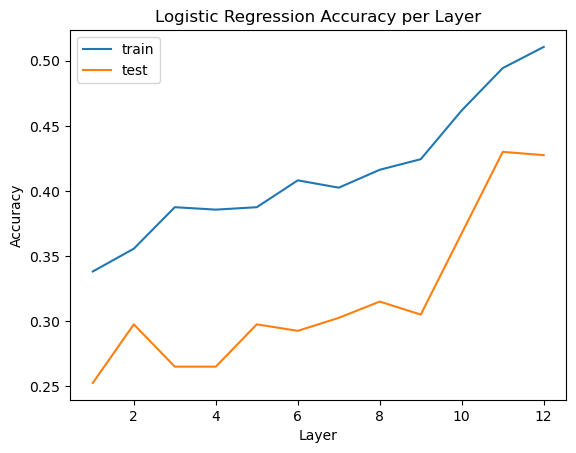

In [13]:
# plot lr_acc per layer

lr_train_accs = [probe_acc(x_train[:,i-1,:num_classes], lr_probes[i]) for i in range(1,13)]
lr_test_accs = [probe_acc(x_test[:,i-1,:num_classes], lr_probes[i]) for i in range(1,13)]
indices = np.arange(1,13)

plt.plot(indices, lr_train_accs, label='train')
plt.plot(indices, lr_test_accs, label='test')
plt.legend()
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy per Layer")
plt.show()

In [14]:
#load in gabe_probes from probes/gabe_probes.pkl
with open("probes/gabe_probes.pkl", "rb") as f:
    gabe_probes = pickle.load(f)
with open("probes/history.pkl", "rb") as f:
    history = pickle.load(f)

In [19]:
epochs = 50000
num_attempts = 5
num_classes = 4

In [ ]:

epochs = 50000
num_attempts = 5

gabe_probes = {}
gabe_losses = {}
gabe_loss_history = {}

train_loss_history = {}
test_loss_history = {}
train_acc_history = {}
test_acc_history = {}

for num_classes in [4, 3, 2]:
    print(f"starting k = {num_classes}")
    for layer in range(12, 0, -1): #
        print(f"starting layer {layer}")

        for attempt in range(num_attempts):
            p = Probe().to(DEVICE)
            optimizer = torch.optim.Adam(p.parameters(), lr=0.00001)
            for i in range(epochs):
                optimizer.zero_grad()
                loss = gabe_loss(x_train[:, layer-1, :num_classes], p)
                loss.backward()
                optimizer.step()
                if i % 100 == 0:
                    train_loss_history[(num_classes, layer, attempt, i)] = gabe_loss(x_train[:, layer-1, :num_classes], p).item()
                    test_loss_history[(num_classes, layer, attempt, i)] = gabe_loss(x_test[:, layer-1, :num_classes], p).item()
                    train_acc_history[(num_classes, layer, attempt, i)] = probe_acc(x_train[:, layer-1, :num_classes], p)
                    test_acc_history[(num_classes, layer, attempt, i)] = probe_acc(x_test[:, layer-1, :num_classes], p)
                    # if i == epochs-100 and attempt == num_attempts-1:
                    #     print(f'layer {layer} attempt {attempt} epoch {i} train_loss {train_loss_history[(layer, attempt, i)]} test_loss {test_loss_history[(layer, attempt, i)]} train_acc {train_acc_history[(layer, attempt, i)]} test_acc {test_acc_history[(layer, attempt, i)]}')
            
            gabe_probes[(num_classes, layer, attempt)] = p
        
        print(f"finished layer {layer}, representative test_acc={test_acc_history[(num_classes, layer, 0, epochs-100)]}")
    
    with open(f'probes/gabe_probes_{num_classes}+.pkl', 'wb') as f:
        pickle.dump(gabe_probes, f)
        

In [ ]:
# plot both losses and accuracies on same graph
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot([train_loss_history[(4,12,0,i)] for i in range(0,epochs,100)], label=f'train loss')
plt.plot([test_loss_history[(4,12,0,i)] for i in range(0,epochs,100)], label=f'test loss')
plt.title("Probe loss over time (k=4)")
plt.legend()

plt.subplot(2,1,2)
plt.plot([train_acc_history[(4,12,0,i)] for i in range(0,epochs,100)], label=f'train acc')
plt.plot([test_acc_history[(4,12,0,i)] for i in range(0,epochs,100)], label=f'test acc')
plt.title("Probe accuracy over time (k=4)")
plt.legend()
plt.show()


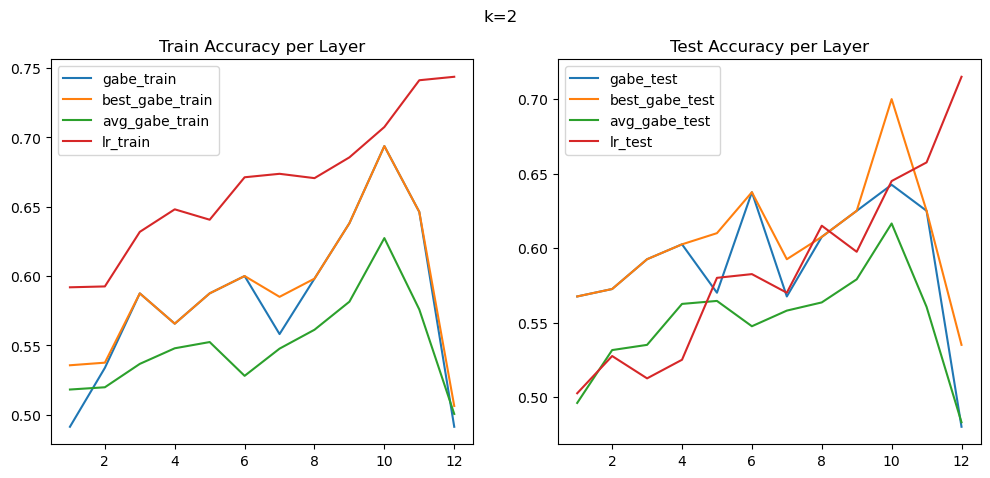

In [41]:
# plot gabe_acc per layer
num_classes = 2

best_gabe_train_accs = [max([probe_acc(x_train[:,i-1,:num_classes], gabe_probes[(num_classes, i, att)]) for att in range(num_attempts)]) for i in range(1,13)]
best_gabe_test_accs = [max([probe_acc(x_test[:,i-1,:num_classes], gabe_probes[(num_classes, i, att)]) for att in range(num_attempts)]) for i in range(1,13)]
avg_gabe_train_accs = [sum([probe_acc(x_train[:,i-1,:num_classes], gabe_probes[(num_classes, i, att)]) for att in range(num_attempts)])/num_attempts for i in range(1,13)]
avg_gabe_test_accs = [sum([probe_acc(x_test[:,i-1,:num_classes], gabe_probes[(num_classes, i, att)]) for att in range(num_attempts)])/num_attempts for i in range(1,13)]
gabe_train_accs = [max(
    [(gabe_loss(x_train[:,i-1,:num_classes], gabe_probes[(num_classes, i, att)]),
      probe_acc(x_train[:,i-1,:num_classes], gabe_probes[(num_classes, i, att)])) for att in range(num_attempts)])[1]
        for i in range(1,13)]
gabe_test_accs = [max(
    [(gabe_loss(x_train[:,i-1,:num_classes], gabe_probes[(num_classes, i, att)]),
      probe_acc(x_test[:,i-1,:num_classes], gabe_probes[(num_classes, i, att)])) for att in range(num_attempts)])[1]
        for i in range(1,13)]

lr_train_accs = [probe_acc(x_train[:,i-1,:num_classes], lr_probes[i]) for i in range(1,13)]
lr_test_accs = [probe_acc(x_test[:,i-1,:num_classes], lr_probes[i]) for i in range(1,13)]

indices = np.arange(1,13)

plt.figure(figsize=(12,5))
plt.suptitle(f"k={num_classes}")

plt.subplot(1,2,1)
plt.plot(indices, gabe_train_accs, label='gabe_train')
plt.plot(indices, best_gabe_train_accs, label='best_gabe_train')
plt.plot(indices, avg_gabe_train_accs, label='avg_gabe_train')
plt.plot(indices, lr_train_accs, label='lr_train')
plt.legend()
plt.title("Train Accuracy per Layer")
plt.subplot(1,2,2)
plt.plot(indices, gabe_test_accs, label='gabe_test')
plt.plot(indices, best_gabe_test_accs, label='best_gabe_test')
plt.plot(indices, avg_gabe_test_accs, label='avg_gabe_test')
plt.plot(indices, lr_test_accs, label='lr_test')
plt.legend()
plt.title("Test Accuracy per Layer")
plt.show()


In [ ]:
display_layer = 10

fig = plt.figure(constrained_layout=True, figsize=(12,12))
fig.suptitle(f"Probe output on correct vs incorrect completion in Layer {display_layer}.")

subfigs = fig.subfigures(2, 1)
subfigs[0].suptitle("Linear Regression", color="green")
ax = subfigs[0].subplots(1, 2)
ax[0].scatter(lr_probes[display_layer](x_train[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            lr_probes[display_layer](x_train[:,display_layer-1,1]).squeeze(-1).detach().cpu())
ax[0].set_title("Train data")
ax[0].set_xlabel("Prob. assigned to correct completion")
ax[0].set_ylabel("Prob. assigned to incorrect completion")

ax[1].scatter(lr_probes[display_layer](x_test[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            lr_probes[display_layer](x_test[:,display_layer-1,1]).squeeze(-1).detach().cpu())
ax[1].set_title("Test data")

#add line y=x
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color="red")
ax[1].plot(x, x, color="red")


#Do the same for Gabe
subfigs[1].suptitle("Gabe", color="green")
ax = subfigs[1].subplots(1, 2)
ax[0].scatter(gabe_probes[display_layer](x_train[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            gabe_probes[display_layer](x_train[:,display_layer-1,1]).squeeze(-1).detach().cpu())
ax[1].scatter(gabe_probes[display_layer](x_test[:,display_layer-1,0]).squeeze(-1).detach().cpu(),
            gabe_probes[display_layer](x_test[:,display_layer-1,1]).squeeze(-1).detach().cpu())

#add line y=x
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color="red")
ax[1].plot(x, x, color="red")

plt.show()

In [25]:
lots_of_probes = []
num_attempts = 50 - len(lots_of_probes)
layer = 6
num_classes = 3

epochs = 50000

for attempt in tqdm(range(num_attempts)):
    p = Probe().to(DEVICE)
    optimizer = torch.optim.Adam(p.parameters(), lr=0.00001)
    for i in range(epochs):
        optimizer.zero_grad()
        loss = gabe_loss(x_train[:, layer-1, :num_classes], p)
        loss.backward()
        optimizer.step()
    lots_of_probes.append(p)

    # with open("probes/lots_of_probes.pkl", "wb") as f:
        # pickle.dump(lots_of_probes, f)

100%|██████████| 32/32 [40:44<00:00, 76.38s/it]


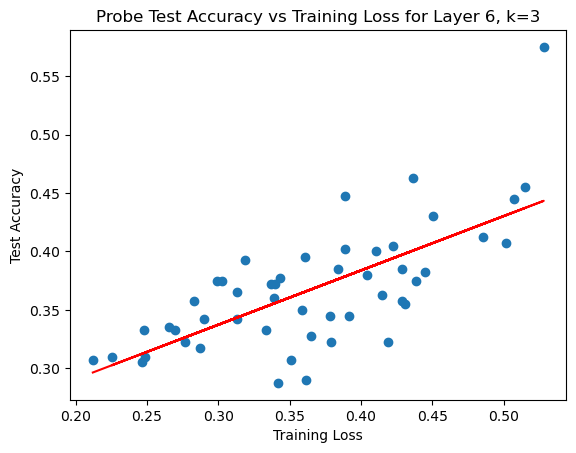

In [40]:
# plot probe final test accuracy vs training loss for layer 10, k=4
layer = 6
num_classes = 3

train_loss = [gabe_loss(x_train[:, layer-1, :num_classes], p).item() for p in lots_of_probes]
test_accs = [probe_acc(x_test[:, layer-1, :num_classes], p) for p in lots_of_probes]

# include trend line
z = np.polyfit(train_loss, test_accs, 1)
p = np.poly1d(z)
plt.plot(train_loss, p(train_loss), "r")

plt.scatter(train_loss, test_accs)
plt.xlabel("Training Loss")
plt.ylabel("Test Accuracy")
plt.title(f"Probe Test Accuracy vs Training Loss for Layer {layer}, k={num_classes}")
plt.show()
    